# XGBoost, LightGBM and CatBoost Parameter Tuning: Results

Using a GPU, we can train a model in a few minutes and evaluate several hundred parameter combinations in a matter of hours, which would take many days using the sklearn implementation. 

For the LightGBM model, we explore both a factor version that uses the libraries' ability to handle categorical variables and a dummy version that uses one-hot encoding.

The evaluation relies on the results produced by the notebook [xgboost_lightgbm_catboost_tuning](05_xgboost_lightgbm_catgboost_tuning.ipynb) and stored in the `results/model_tuning.h5` HDF5 store. Sample results for the below outputs shown in the book are included. 

## Imports & Settings

In [44]:
%matplotlib inline

import warnings
from pathlib import Path
import os
from datetime import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from statsmodels.api import OLS, add_constant
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.externals import joblib

In [45]:
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
np.random.seed(42)

In [46]:
with pd.HDFStore('results/model_tuning.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: results/model_tuning.h5
/catboost/factors/results             frame        (shape->[96,64])   
/holdout/features                     frame        (shape->[16695,84])
/holdout/target                       series       (shape->[16695])   
/lightgbm/dummies/results             frame        (shape->[396,29])  
/lightgbm/factors/results             frame        (shape->[396,29])  
/lightgbm/holdout/features            frame        (shape->[16695,84])
/lightgbm/holdout/target              series       (shape->[16695])   
/xgboost/dummies/results              frame        (shape->[216,20])  
/xgboost/holdout/features             frame        (shape->[16695,84])
/xgboost/holdout/target               series       (shape->[16695])   


## Keep only parameters used for grid search

In [47]:
with pd.HDFStore('results/model_tuning.h5') as source:
    with pd.HDFStore('results.h5') as target:
        results = [k for k in source.keys() if k.endswith('results')]
        for result in results:
            print(result)
            df = source[result]

            # drop info that doesn't change across models
            uniques = df.astype(str).nunique()
            df = df.loc[:, uniques[uniques>1].index]
            target.put('/'.join(result[1:].split('/')[:2]),
                           df.sort_values('valid', ascending=False).reset_index(drop=True))

/xgboost/dummies/results
/lightgbm/factors/results
/lightgbm/dummies/results
/catboost/factors/results


In [15]:
with pd.HDFStore('results.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: results.h5
/catboost/factors            frame        (shape->[96,9]) 
/lightgbm/dummies            frame        (shape->[1,14]) 
/lightgbm/factors            frame        (shape->[1,14]) 
/xgboost/dummies             frame        (shape->[216,9])


## Validation Performance

When comparing average cross-validation AUC across the four test runs with the three libraries, we find that CatBoost produces a slightly higher AUC score for the top-performing model, while also producing the widest dispersion of outcomes, as shown in the below graph.

### All models

In [16]:
with pd.HDFStore('results.h5') as store:
    for key in store.keys()[:1]:
        df = store[key].sort_values('valid', ascending=False)
        print('\n', key.split('/')[1])
        print(df.head())
        df.iloc[0].to_csv('catboost_best.csv')


 xgboost
      rounds     train     valid booster  learning_rate  gamma  max_depth  \
0  59.166667  0.798142  0.683618  gbtree            0.1      1          9   
2  59.166667  0.798142  0.683618  gbtree            0.1      0          9   
1  59.166667  0.798142  0.683618  gbtree            0.1      5          9   
3  47.666667  0.790726  0.681356    dart            0.1      1          9   
5  47.666667  0.790726  0.681356    dart            0.1      0          9   

   colsample_bytree        time  
0               1.0   85.372013  
2               1.0   75.323257  
1               1.0   94.299514  
3               0.8  564.300030  
5               0.8  490.855656  


In [17]:
models = ['catboost/factors', 'lightgbm/dummies', 'lightgbm/factors', 'xgboost/dummies']
df = pd.DataFrame()
with pd.HDFStore('results.h5') as store:
    for k in models:
        model = k.split('/')[0]
        data = k.split('/')[1]
        df = pd.concat([df, store[k][['train', 'valid', 'time']].assign(model=model, data=data)])
df['Model'] = df.model.str.capitalize().str.cat(df.data.str.capitalize(), sep=' ')        
df = df.drop(['model', 'data'], axis=1).rename(columns={'valid': 'Validation AUC'})
df.info()    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1104 entries, 0 to 215
Data columns (total 4 columns):
train             1104 non-null float64
Validation AUC    1104 non-null float64
time              1104 non-null float64
Model             1104 non-null object
dtypes: float64(3), object(1)
memory usage: 43.1+ KB


In [18]:
top_scores = df.groupby('Model')['Validation AUC'].max().sort_values(ascending=False).to_dict()

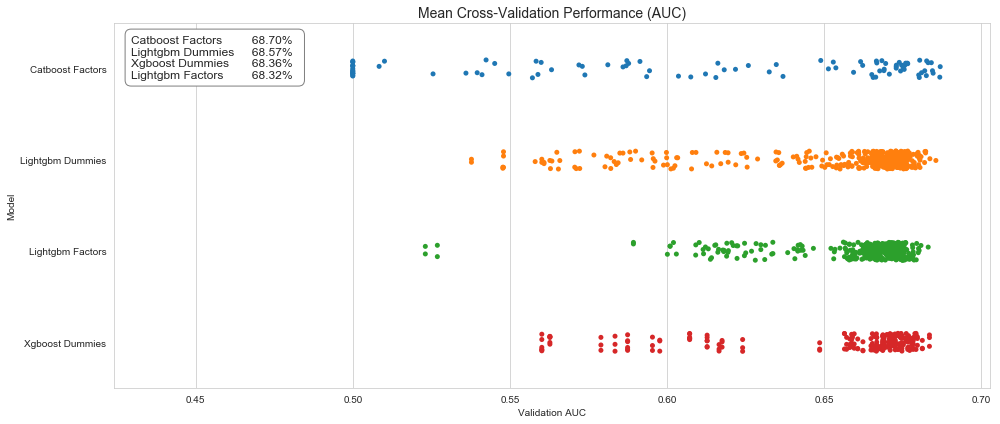

In [19]:
plt.figure(figsize=(14,6))
ax = sns.stripplot(x='Validation AUC', y='Model', data=df)
ax.set_title('Mean Cross-Validation Performance (AUC)', fontsize=14)
ax.text(x=.02, y=.85, s='\n'.join([f'{m:<35}' for m, s in top_scores.items()]),
            transform=ax.transAxes, fontsize=12, 
            bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.5'))
ax.text(x=.15, y=.85, s='\n'.join([f'{s:>8.2%}' for m, s in top_scores.items()]),
            transform=ax.transAxes, fontsize=12)
plt.tight_layout();

## Combine Model Results

Collect results for each model:

In [20]:
cols = ['model', 'data', 'train', 'valid', 'boosting', 'learning_rate', 'max_depth', 'num_leaves',
        'colsample_bytree', 'min_gain_to_split', 'rounds', 'time']

with pd.HDFStore('results.h5') as store:
    xgb = (store['xgboost/dummies']
           .rename(columns={'booster': 'boosting', 'gamma': 'min_gain_to_split'})
           .assign(model='xgb', data='dummies'))

    lgb_dummies = (store['lightgbm/dummies']
                   .assign(model='lightgbm', data='dummies'))
    lgb_dummies.boosting = lgb_dummies.boosting.str.replace('gbdt', 'gbtree')

    lgb_factors = (store['lightgbm/factors']
                   .assign(model='lightgbm', data='factors'))

In [21]:
xgb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216 entries, 0 to 215
Data columns (total 11 columns):
rounds               216 non-null float64
train                216 non-null float64
valid                216 non-null float64
boosting             216 non-null object
learning_rate        216 non-null float64
min_gain_to_split    216 non-null int64
max_depth            216 non-null int64
colsample_bytree     216 non-null float64
time                 216 non-null float64
model                216 non-null object
data                 216 non-null object
dtypes: float64(6), int64(2), object(3)
memory usage: 20.2+ KB


In [22]:
lgb_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396 entries, 0 to 395
Data columns (total 16 columns):
boosting             396 non-null object
colsample_bytree     396 non-null float64
gamma                180 non-null float64
learning_rate        396 non-null float64
max_depth            396 non-null int64
min_gain_to_split    396 non-null int64
num_leaves           396 non-null int64
rounds               396 non-null float64
rounds_std           180 non-null float64
time                 396 non-null float64
train                396 non-null float64
train_std            180 non-null float64
valid                396 non-null float64
valid_std            180 non-null float64
model                396 non-null object
data                 396 non-null object
dtypes: float64(10), int64(3), object(3)
memory usage: 52.6+ KB


In [23]:
lgb_factors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396 entries, 0 to 395
Data columns (total 16 columns):
boosting             396 non-null object
colsample_bytree     396 non-null float64
gamma                180 non-null float64
learning_rate        396 non-null float64
max_depth            396 non-null int64
min_gain_to_split    396 non-null int64
num_leaves           396 non-null int64
rounds               396 non-null float64
rounds_std           180 non-null float64
time                 396 non-null float64
train                396 non-null float64
train_std            180 non-null float64
valid                396 non-null float64
valid_std            180 non-null float64
model                396 non-null object
data                 396 non-null object
dtypes: float64(10), int64(3), object(3)
memory usage: 52.6+ KB


Combine LightGBM and XGBoost results that have largely the same hyperparameters.

In [24]:
lgb_xgb_combined = (lgb_dummies
                    .append(lgb_factors)
                    .append(xgb, ignore_index=True)).loc[:, cols]

lgb_xgb_combined['model_type'] = lgb_xgb_combined.model.str.capitalize(
).str.cat(lgb_xgb_combined.data.str.capitalize(), sep=' ')
lgb_xgb_combined = lgb_xgb_combined.drop(['model', 'data'], axis=1)

lgb_xgb_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 11 columns):
train                1008 non-null float64
valid                1008 non-null float64
boosting             1008 non-null object
learning_rate        1008 non-null float64
max_depth            1008 non-null int64
num_leaves           792 non-null float64
colsample_bytree     1008 non-null float64
min_gain_to_split    1008 non-null int64
rounds               1008 non-null float64
time                 1008 non-null float64
model_type           1008 non-null object
dtypes: float64(7), int64(2), object(2)
memory usage: 86.7+ KB


### Best Performing Models

A more detailed look at the top-performing models for the LightGBM and XGBoost models shows that the LightGBM Factors model achieves nearly as good a performance as the other two models with much lower model complexity. 

It only consists on average of 41 trees up to three levels deep with no more than eight leaves each, while also using regularization in the form of min_gain_to_split. It overfits significantly less on the training set, with a train AUC only slightly above the validation AUC. 

It also trains much faster, taking only 18 seconds per model because of its lower complexity. In practice, this model would be preferable since it is more likely to produce good out-of-sample performance. The details are shown in the following table:

| Metric            | Lightgbm Dummies | Xgb Dummies | Lightgbm Factors | CatBoost |
|-------------------|------------------|-------------|------------------|----------|
| Validation AUC    | 68.57%           | 68.36%      | 68.32%           | 68.70%   |
| Train AUC         | 82.35%           | 79.81%      | 72.12%           | 73.61%   |
| learning_rate     | 0.1              | 0.1         | 0.3              |          |
| max_depth         | 13               | 9           | 3                | 12       |
| num_leaves        | 8192             |             | 8                |          |
| colsample_bytree  | 0.8              | 1           | 1                |          |
| min_gain_to_split | 0                | 1           | 0                |          |
| rounds            | 44.42            | 59.17       | 41.00            | 22.33    |
| time              | 86.55            | 85.37       | 18.78            | 229.66   |

In [25]:
lgb_xgb_combined.sort_values('valid', ascending=False).head(10)

,train,valid,boosting,learning_rate,max_depth,num_leaves,colsample_bytree,min_gain_to_split,rounds,time,model_type
0,0.823529,0.685673,gbtree,0.1,13,8192.0,0.8,0,44.416667,86.548636,Lightgbm Dummies
1,0.803322,0.683760,gbtree,0.1,12,4096.0,0.8,0,34.916667,63.578490,Lightgbm Dummies
792,0.798142,0.683618,gbtree,0.1,9,NaN,1.0,1,59.166667,85.372013,Xgb Dummies
793,0.798142,0.683618,gbtree,0.1,9,NaN,1.0,5,59.166667,94.299514,Xgb Dummies
794,0.798142,0.683618,gbtree,0.1,9,NaN,1.0,0,59.166667,75.323257,Xgb Dummies
396,0.721158,0.683226,gbdt,0.3,3,8.0,1.0,0,41.000000,18.782672,Lightgbm Factors
2,0.801764,0.682428,gbtree,0.1,11,2048.0,1.0,0,53.916667,71.732526,Lightgbm Dummies
3,0.785657,0.682390,dart,0.1,13,8192.0,1.0,0,54.166667,171.725467,Lightgbm Dummies
4,0.729307,0.682187,gbtree,0.3,7,128.0,0.6,5,18.833333,15.769092,Lightgbm Dummies
5,0.774811,0.682066,gbtree,0.1,9,512.0,0.8,0,53.916667,46.393234,Lightgbm Dummies


In [26]:
lgb_xgb_combined.groupby('model_type').apply(lambda x: x.sort_values('valid', ascending=False).head(1)).reset_index(-1, drop=True).T.to_csv('best_models.csv')

### Decision Tree for all models

In [27]:
reg_tree = DecisionTreeRegressor(criterion='mse',
                                 splitter='best',
                                 min_samples_split=2,
                                 min_samples_leaf=2,
                                 min_weight_fraction_leaf=0.0,
                                 max_features=None,
                                 random_state=42,
                                 max_leaf_nodes=None,
                                 min_impurity_decrease=0.0,
                                 min_impurity_split=None,
                                 presort=False)

In [28]:
test_score = lgb_xgb_combined.valid
feature_data = lgb_xgb_combined.drop(['train', 'valid', 'time', 'rounds'], axis=1).fillna(-1)
feature_data = pd.get_dummies(feature_data, columns=feature_data.columns)
features = feature_data.columns
reg_tree.fit(X=feature_data, y=test_score)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

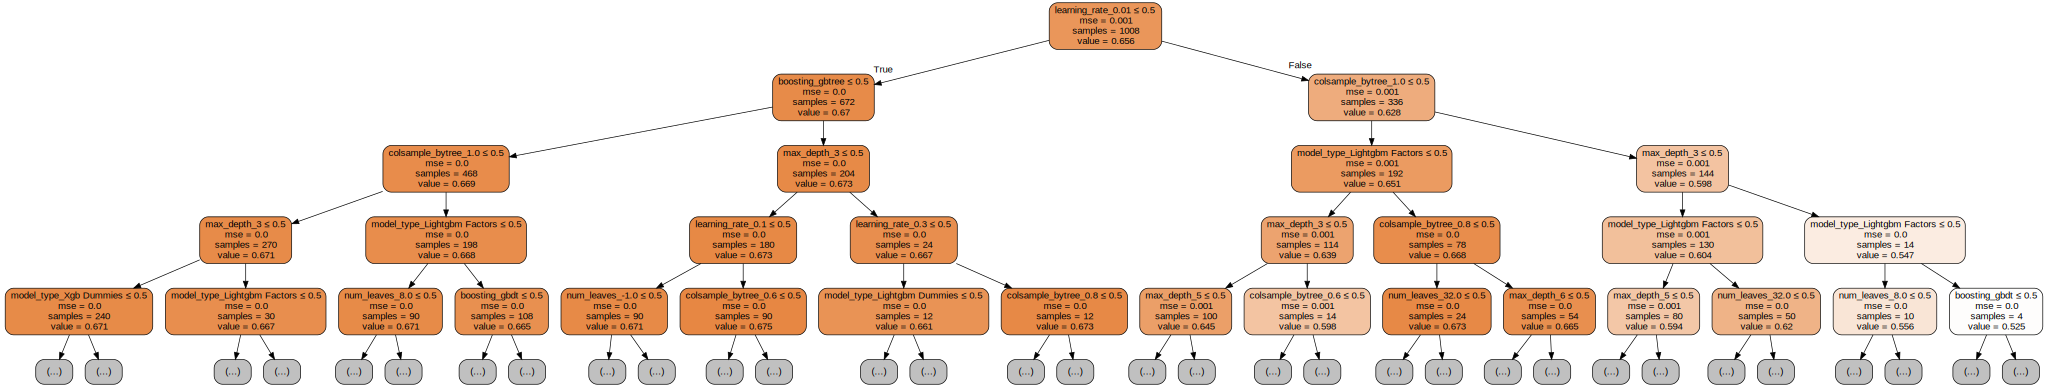

In [29]:
# out_file = 'model_tuning/xgb_tree.dot'
out_file = None
dot_data = export_graphviz(reg_tree,
                          out_file=out_file,
                          feature_names=features,
                          max_depth=4,
                          filled=True,
                          rounded=True,
                          special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

In [30]:
pd.Series(reg_tree.feature_importances_, index=features).sort_values(ascending=False).head(10)

learning_rate_0.01             0.435011
colsample_bytree_1.0           0.250942
max_depth_3                    0.077323
model_type_Lightgbm Factors    0.070071
max_depth_5                    0.041259
colsample_bytree_0.6           0.027643
num_leaves_16.0                0.014961
max_depth_4                    0.009869
max_depth_7                    0.008298
boosting_dart                  0.007767
dtype: float64

## XGB Parameter Usage

The following plot shows the effect of different max_depth settings on the validation score for the LightGBM and XGBoost models: shallower trees produce a wider range of outcomes and need to be combined with appropriate learning rates and regularization settings to produce the strong result shown in the preceding table:

In [31]:
reg_tree = DecisionTreeRegressor(criterion='mse',
                                 splitter='best',
                                 max_depth=4,
                                 min_samples_split=5,
                                 min_samples_leaf=10,
                                 min_weight_fraction_leaf=0.0,
                                 max_features=None,
                                 random_state=42,
                                 max_leaf_nodes=None,
                                 min_impurity_decrease=0.0,
                                 min_impurity_split=None,
                                 presort=False)

In [32]:
test_score = lgb_xgb_combined.valid
feature_data = lgb_xgb_combined.drop(['train', 'valid', 'time', 'rounds'], axis=1).fillna(-1)
feature_data = pd.get_dummies(feature_data, columns=feature_data.columns)
features = feature_data.columns
reg_tree.fit(X=feature_data, y=test_score)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [33]:
xgb_data = lgb_xgb_combined[(lgb_xgb_combined.model_type=='Xgb Dummies')]
xgb_data.boosting = pd.factorize(xgb_data.boosting)[0]
xgb_features = ['boosting', 'learning_rate', 'max_depth', 'colsample_bytree', 'min_gain_to_split']
reg_tree.fit(X=xgb_data[xgb_features], y=xgb_data.valid)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

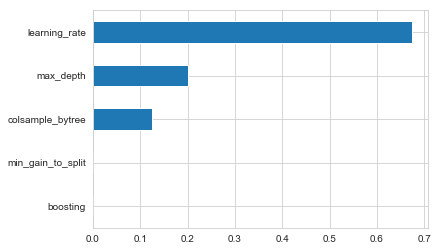

In [34]:
pd.Series(reg_tree.feature_importances_, index=xgb_features).sort_values().plot.barh();

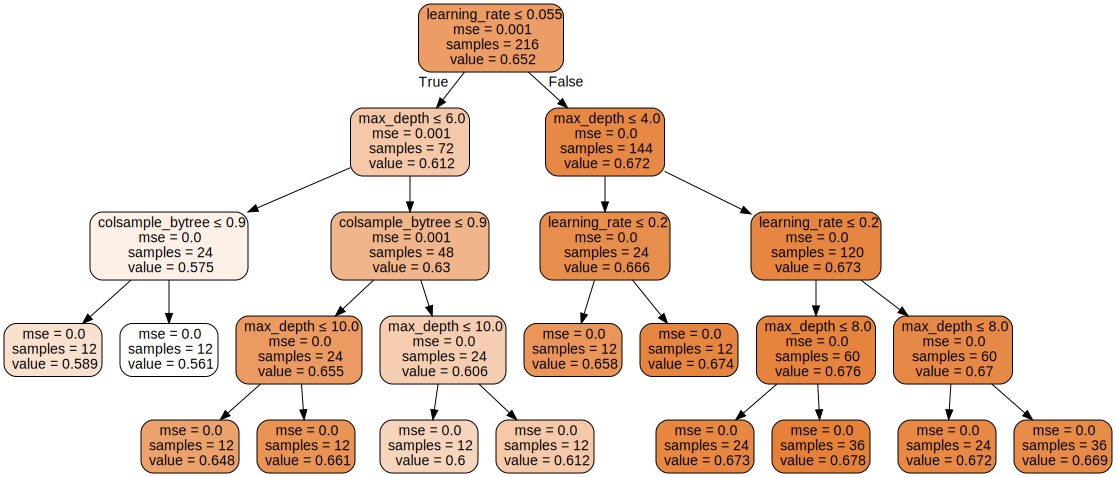

In [36]:
out_file = 'results/xgb_tree.dot'
dot_data = export_graphviz(reg_tree,
                          out_file=out_file,
                          feature_names=xgb_features,
                          max_depth=4,
                          filled=True,
                          rounded=True,
                          special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

## Overall Validation Performance

In [37]:
models = ['catboost/factors', 'lightgbm/dummies', 'lightgbm/factors', 'xgboost/dummies']
df = pd.DataFrame()
with pd.HDFStore('results.h5') as store:
    for k in models:
        model = k.split('/')[0]
        data = k.split('/')[1]
        df = pd.concat([df, store[k][['train', 'valid', 'time']].assign(model=model, data=data)])
df['Model'] = df.model.str.capitalize().str.cat(df.data.str.capitalize(), sep=' ')        
df = df.drop(['model', 'data'], axis=1).rename(columns={'valid': 'Validation AUC'})
df.info()    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1104 entries, 0 to 215
Data columns (total 4 columns):
train             1104 non-null float64
Validation AUC    1104 non-null float64
time              1104 non-null float64
Model             1104 non-null object
dtypes: float64(3), object(1)
memory usage: 43.1+ KB


### LightGBM vs XGBoost

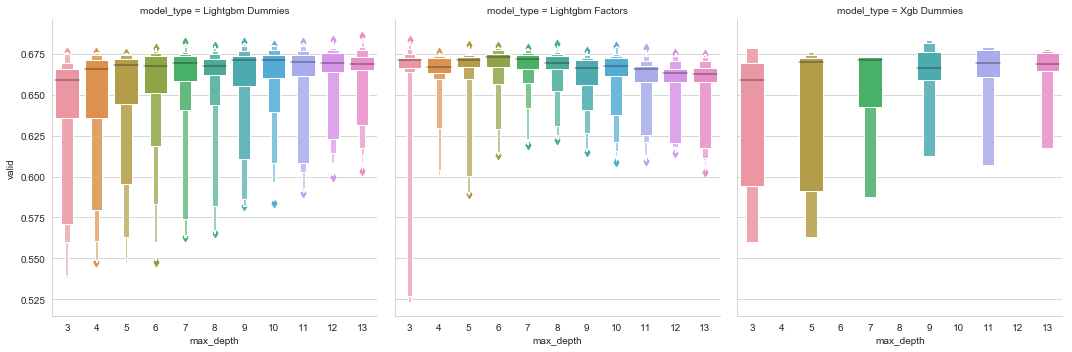

In [38]:
sns.catplot(x='max_depth', y='valid', col='model_type', data=lgb_xgb_combined, kind='boxen');

## Hyperparameter Impact Evaluation using Linear Regression

Instead of a DecisionTreeRegressor as shown previously, we can also use linear regression to evaluate the statistical significance of different features concerning the validation AUC score. 

For the LightGBM Dummy model, where the regression explains 68% of the variation in outcomes, we find that only the min_gain_to_split regularization parameter was not significant, as shown below:

In [40]:
features = ['boosting','learning_rate', 'max_depth', 'colsample_bytree', 'min_gain_to_split']
path = Path('ols_results')
for model, data in lgb_xgb_combined.groupby('model_type'):
    y = data.valid 
    X = pd.get_dummies(data[features].dropna(how='all', axis=1), columns=features, drop_first=True)
    ols = OLS(endog=y, exog=add_constant(X)).fit(cov_type='HC3')
    print('\n', model)
    print(ols.summary())    


 Lightgbm Dummies
                            OLS Regression Results                            
Dep. Variable:                  valid   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     26.94
Date:                Sat, 20 Apr 2019   Prob (F-statistic):           7.92e-55
Time:                        14:39:20   Log-Likelihood:                 1018.7
No. Observations:                 396   AIC:                            -2001.
Df Residuals:                     378   BIC:                            -1930.
Df Model:                          17                                         
Covariance Type:                  HC3                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const        

### CatBoost

In [41]:
cat_features = ['max_depth', 'max_bin', 'max_ctr_complexity',  'one_hot_max_size',  'random_strength']
with pd.HDFStore('results.h5') as store:
    cat_data = store['catboost/factors']
cat_data.info()    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96 entries, 0 to 95
Data columns (total 9 columns):
rounds                96 non-null float64
train                 96 non-null float64
valid                 96 non-null float64
max_depth             96 non-null int64
max_bin               96 non-null int64
max_ctr_complexity    96 non-null int64
one_hot_max_size      48 non-null float64
random_strength       48 non-null float64
time                  96 non-null float64
dtypes: float64(6), int64(3)
memory usage: 7.5 KB


In [42]:
reg_tree.fit(X=cat_data[cat_features].fillna(-1), y=cat_data.valid)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

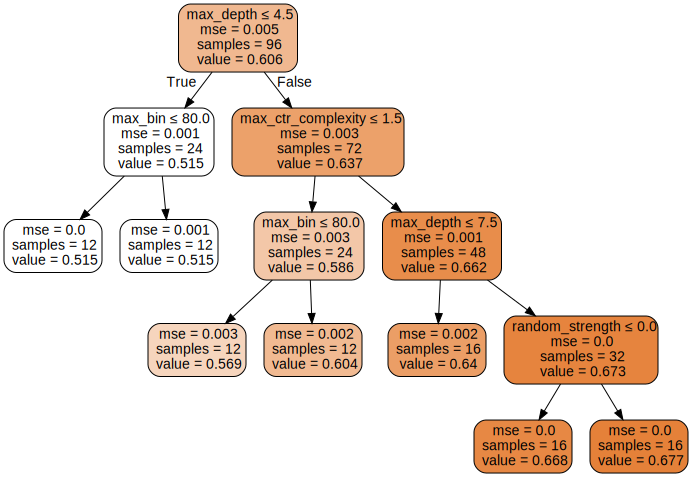

In [43]:
out_file = 'results/cat_tree.dot'
dot_data = export_graphviz(reg_tree,
                          out_file=out_file,
                          feature_names=cat_features,
                          max_depth=4,
                          filled=True,
                          rounded=True,
                          special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)